In [1]:
import tensorflow as tf

import numpy as np
import os
from kaggle_datasets import KaggleDatasets

In [2]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path("agedetection")
TRAIN_PATH = GCS_DS_PATH + "/dataset/dataset"

HEIGHT,WIDTH = 128,128
CHANNELS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
SEED = 143

AUTO = tf.data.experimental.AUTOTUNE
print(GCS_DS_PATH)

gs://kds-6d3cf3666dde7c685207ed552ff146f9f315e466366bade3da15dd2d


In [4]:
def process_img(filepath,label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) 
        
    
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.8), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

In [5]:
files_ls = tf.io.gfile.glob(TRAIN_PATH + '/*.jpg')
filenames = [name.split("/")[-1] for name in files_ls]

age_label = np.array(tf.one_hot([int(name.split("_")[0])//10 for name in filenames],depth=12))
gender_label = np.array(tf.one_hot([int(name.split("_")[1]) for name in filenames],depth=2))
ethnicity_label = np.array(tf.one_hot([int(name.split("_")[2]) for name in filenames],depth=5))

labels = np.concatenate((age_label,gender_label,ethnicity_label),axis=1)

dataset = tf.data.Dataset.from_tensor_slices((files_ls,labels))
dataset = dataset.map(process_img,num_parallel_calls=AUTO).prefetch(AUTO)
dataset = dataset.map(data_augment,num_parallel_calls=AUTO).prefetch(AUTO)

SPLIT = int(0.8*len(files_ls))
train_ds = dataset.take(SPLIT)
val_ds = dataset.skip(SPLIT)

train_ds = train_ds.cache().repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = val_ds.cache().repeat().batch(BATCH_SIZE).prefetch(AUTO)

STEPS_PER_EPOCH  = SPLIT//BATCH_SIZE
VALID_STEPS = (len(files_ls)-SPLIT)//BATCH_SIZE

In [6]:
def create_model():
    
    pretrained = tf.keras.applications.MobileNetV2(include_top=False,weights="imagenet",input_shape = (HEIGHT,WIDTH,CHANNELS))
    
    inputs = tf.keras.Input(shape = (HEIGHT,WIDTH,CHANNELS))
    x = pretrained(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    outputs = tf.keras.layers.Dense(19,activation="sigmoid")(x)

    
    model = tf.keras.Model(inputs,outputs)
    return model

model = create_model()
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 19)                24339     
Total params: 2,282,323
Trainable params: 2,248,211
Non-trainable params: 34,112
_________________________________________________________________


In [7]:
def compile_model(model, lr=0.001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [8]:
def create_callbacks():
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="./best_model.h5",
        save_weights_only=False,
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        save_freq='epoch',
        verbose = 1
    )
    
    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= 'val_acc',
        mode='max',
        factor=0.5,
        patience=3,
        verbose=1
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= 'val_acc',
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]
    return callbacks

In [9]:
EPOCHS= 40
VERBOSE =1

tf.keras.backend.clear_session()

with strategy.scope():
    
    model = create_model()
    model = compile_model(model, lr=0.001)
   
    callbacks = create_callbacks()
    
    history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        validation_steps=VALID_STEPS
                       )

Epoch 1/40
296/296 [==============================] - 1364s 4s/step - loss: 0.2430 - acc: 0.8909 - val_loss: 1.5170 - val_acc: 0.8798

Epoch 00001: val_acc improved from -inf to 0.87980, saving model to ./best_model.h5
Epoch 2/40
296/296 [==============================] - 11s 37ms/step - loss: 0.1890 - acc: 0.9217 - val_loss: 1.9510 - val_acc: 0.8421

Epoch 00002: val_acc did not improve from 0.87980
Epoch 3/40
296/296 [==============================] - 11s 36ms/step - loss: 0.1725 - acc: 0.9301 - val_loss: 1.6752 - val_acc: 0.8184

Epoch 00003: val_acc did not improve from 0.87980
Epoch 4/40
296/296 [==============================] - 11s 37ms/step - loss: 0.1626 - acc: 0.9340 - val_loss: 1.6726 - val_acc: 0.8590

Epoch 00004: val_acc did not improve from 0.87980

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/40
296/296 [==============================] - 11s 37ms/step - loss: 0.1466 - acc: 0.9417 - val_loss: 0.9702 - val_acc: 0.8870

Epoch 0000

In [10]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 2.9 MB/s 


Age is between 21 and 30
Gender is Male
Ethnicity is Black


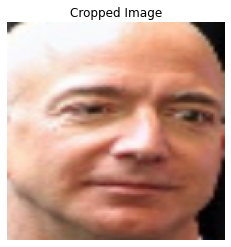

In [11]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt

TEST_PATH = "../input/agedetection/predict.jpg"

gender_dict={
    0:"Male",
    1:"Female"
}

ethnicity_dict = {
  0:"White",
  1:"Black",
  2:"Asian",
  3:"Indian",
  4:"Others"
}

img = tf.keras.preprocessing.image.load_img(TEST_PATH,target_size=(HEIGHT,WIDTH))
img = tf.keras.preprocessing.image.img_to_array(img)

detector = MTCNN()
results = detector.detect_faces(img)

if len(results) == 0:
    print("No Face Detected, Try again")
else:
    x, y, width, height = results[0]['box']
    face = img[y:y+height, x:x+width]
    face = tf.image.resize(face, [HEIGHT,WIDTH])
    face = tf.expand_dims(face,0)
    pred = model.predict(face)
    age = np.argmax(pred[0][:11])
    print(f"Age is between {age*10+1} and {age*10+10}")
    gender = gender_dict[np.argmax(pred[0][12:14])]
    print(f"Gender is {gender}")
    ethnicity = ethnicity_dict[np.argmax(pred[0][14:])]
    print(f"Ethnicity is {ethnicity}")
    
plt.imshow(face[0]/255.)
plt.axis("off")
plt.title("Cropped Image")
plt.show()